# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

# Regression example
This Jupyter Notebook contains a basic example of regression with linear regression, random forest and a deep neural network. The dataset we will use is the insurance dataset, which contains information about individuals and their medical insurance costs. We will preprocess the data, visualize it, and train different models on it. Finally, we will evaluate the models and compare their performance.
First, we install [Pytorch Lightning](https://lightning.ai/), which will be used as an easy-to-use interface to PyTorch.


In [22]:
!pip install pytorch-lightning --quiet

## Data
Download the dataset:

In [23]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

--2024-10-30 23:31:58--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  53,02K  --.-KB/s    in 0,02s   

2024-10-30 23:31:59 (2,31 MB/s) - ‘insurance.csv.1’ saved [54288/54288]



In [26]:
!pip install torchmetrics --quiet

## Imports
Importing libraries for data preprocessing & visualization:

In [ ]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for linear algebra
import matplotlib.pyplot as plt # matplotlib for plotting
import seaborn as sns # seaborn for plotting

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, TensorDataset

import csv
from sklearn.metrics import mean_absolute_error, r2_score


import torch.nn as nn

## DATA PREPROCESSING AND VISUALIZATION

A `df` dataframe is created by reading the contents of the "insurance.csv" file using pandas `read_csv()` method. The "insurance.csv" file contains information about individuals and their medical insurance costs. The `df` dataframe contains 1338 rows and 7 columns. Each row represents an individual and each column represents a feature of that individual such as age, sex, bmi, number of children, smoker or not, region and charges.

In [30]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We have the column names already. There are no 'NaN' values in any of the columns.

The categorical columns contains strings, which have to convert to one-hot vectors. Fortunately, we can easily do this with pandas:

In [32]:
df = pd.get_dummies(df, drop_first=True) # we have to talk about drop_first -> avoid the dummy variable trap
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


In [33]:
df.dtypes

age                   int64
bmi                 float64
children              int64
charges             float64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

In [34]:
df.iloc[:, :4] = df.iloc[:, :4].astype('float32')

/var/folders/dy/crwmhrjj0cqbyz9960bfh8zm0000gn/T/ipykernel_45829/3833803781.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       19.0
1       18.0
2       28.0
3       33.0
4       32.0
        ... 
1333    50.0
1334    18.0
1335    18.0
1336    21.0
1337    61.0
Name: age, Length: 1338, dtype: float32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :4] = df.iloc[:, :4].astype('float32')
/var/folders/dy/crwmhrjj0cqbyz9960bfh8zm0000gn/T/ipykernel_45829/3833803781.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.0
1       1.0
2       3.0
3       0.0
4       0.0
       ... 
1333    3.0
1334    0.0
1335    0.0
1336    0.0
1337    0.0
Name: children, Length: 1338, dtype: float32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,

In [35]:
df.dtypes

age                 float32
bmi                 float64
children            float32
charges             float64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

The following part generates a "heatmap" of pairwise correlations between the features in the `df` dataframe. The `sns.heatmap()` function from the seaborn library is used to create the heatmap. The `annot=True` parameter adds the correlation values to the heatmap.

Pairwise correlation is a measure of the linear relationship between two variables. In the context of linear regression, pairwise correlation is important because it helps us understand how each feature is related to the target variable. If two features are highly correlated, it means that they are providing similar information to the model, which can lead to overfitting. On the other hand, if two features are not correlated, it means that they are providing different information to the model, which can improve the model's performance. Therefore, it is important to check the pairwise correlations between the features before training a linear regression model.

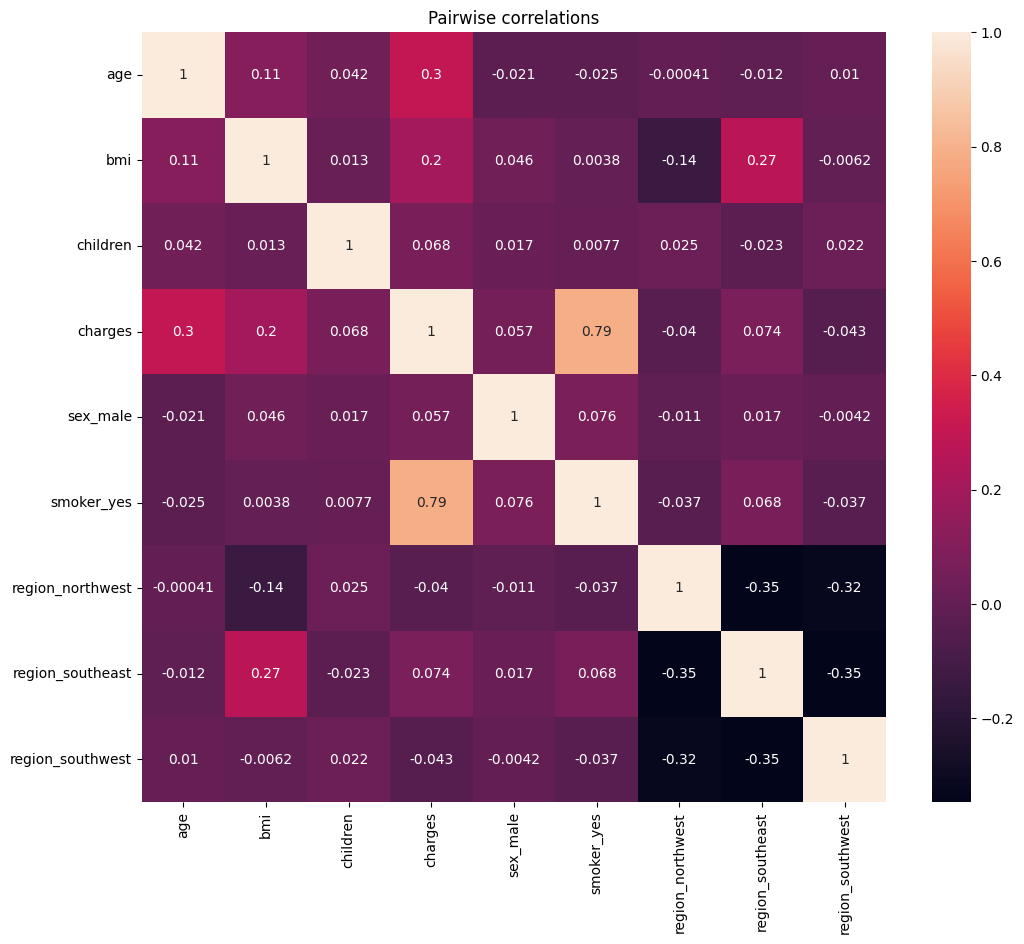

In [36]:
plt.figure(figsize=(12, 10))
plt.title('Pairwise correlations')
sns.heatmap(data=df.corr(), annot=True)
plt.show()

## Training linear regression and random forest regressors

We split the features and the target variable:


In [37]:
X = df.drop(columns=['charges']).values # features
y = df['charges'].values # label

Now we split the dataset into train and test sets, and train linear regression and random forest regressors on the test set.

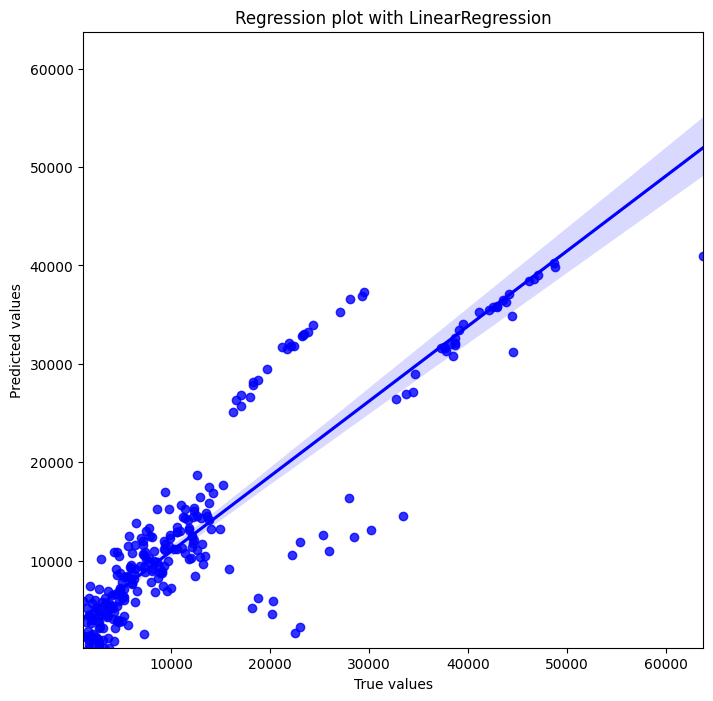

Mean absolute error: 4181.1944608448575
Coefficient of determination: 0.7835929764447832


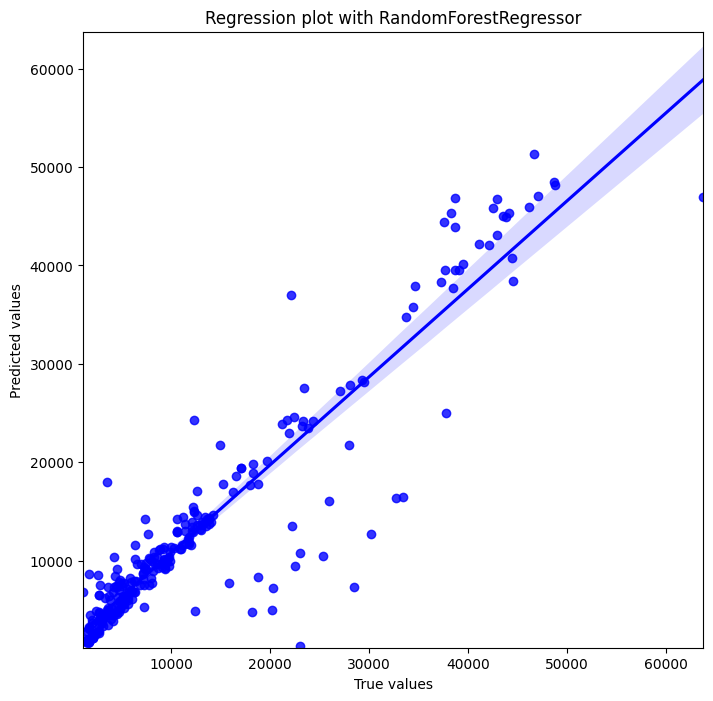

Mean absolute error: 2515.7853885350773
Coefficient of determination: 0.8664288371501921


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # alternative: min-max scaling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

for model in [LinearRegression(), RandomForestRegressor()]:
  model.fit(scaler.transform(X_train), y_train)
  y_pred = model.predict(scaler.transform(X_test))
  np.save(model.__class__.__name__, y_pred)
  # regression plot
  plt.figure(figsize=(8, 8))
  sns.regplot(x=y_test, y=y_pred, scatter=True, color='b')
  plt.xlabel("True values")
  plt.ylabel("Predicted values")
  plt.xlim(min(y_test), max(y_test))
  plt.ylim(min(y_test), max(y_test))
  plt.title(f"Regression plot with {model.__class__.__name__}")
  plt.show()
  # evaluation
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean absolute error: {mae}")
  r2 = r2_score(y_test, y_pred)
  print(f"Coefficient of determination: {r2}")


## **ASSIGNMENT**: Regression with neural network

Your tasks are the following.


---


1. Create and train a FeedForward Neural Network with PyTorch Lightning. Use ModelCheckPoint as callback, and save the best performing model (in terms of MAE) into a ckpt file named *best_model.ckpt*. 50 points


---


2. Save the MAE and the R2 score of your best performing model into a csv file called *mlp_results.csv*. The MAE must be lower and the R2 score must be higher than in linear regression. 20 points.


---


3. Ensemble your neural network model with RandomForestRegressor following the formula
`y_pred_ensemble = 0.5 * y_pred_FeedForwardNet + 0.5 * y_pred_RandomForestRegressor`.
Save the MAE and the R2 score of the ensemble into a csv file called *ensemble_results.csv*.  30 points


---


Besides the Python codes / IPYNB, the CSV files must be saved directly into the git repository you submit.


Some thoughts on ensembles:
*   https://en.wikipedia.org/wiki/Ensemble_learning
*   https://ensemble-pytorch.readthedocs.io/
*   https://arxiv.org/abs/2106.03253

In [43]:

class FeedForwardNet(pl.LightningModule):
    def __init__(self, input_dim):
        super(FeedForwardNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.criterion = nn.MSELoss()
        self.mae = MeanAbsoluteError()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        mae = self.mae(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_mae', mae)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# Prepare data
X_train_tensor = torch.tensor(scaler.transform(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Train the model
checkpoint_callback = ModelCheckpoint(
    monitor='val_mae',
    dirpath='.',
    filename='best_model',
    save_top_k=1,
    mode='min'
)

model = FeedForwardNet(input_dim=X_train.shape[1])
trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/killercookie/Documents/GitHub/School-Code/Deep Learning/3rd Practice (Classifcation & Regresstion) exists and is not empty.

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 2.7 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
--------------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [52]:
def evaluate_best_model():
    # Load the model and move it to the correct device
    best_model_path = "./best_model.ckpt"
    best_model = FeedForwardNet.load_from_checkpoint(best_model_path, input_dim=X_train.shape[1])
    best_model.to(device)
    best_model.eval()
    
    y_pred = []
    y_true = []
    
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)  # Move data to the same device as the model
        with torch.no_grad():
            y_hat = best_model(x)
            y_pred.extend(y_hat.cpu().numpy().flatten())  # Move output back to CPU before converting to NumPy
            y_true.extend(y.cpu().numpy().flatten())
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Save the results to a CSV file
    with open('mlp_results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Metric', 'Value'])
        writer.writerow(['MAE', mae])
        writer.writerow(['R2', r2])

evaluate_best_model()


In [ ]:
def evaluate_ensemble_model(best_model_path, rf_predictions_path, val_loader, y_true):
    # Determine device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # Load the best FeedForwardNet model
    best_model = FeedForwardNet.load_from_checkpoint(best_model_path, input_dim=X_train.shape[1])
    best_model.to(device)  # Move model to the appropriate device
    best_model.eval()
    y_pred_ffn = []

    # Predict with FeedForwardNet on the test/validation data
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)  # Move input tensor to the same device as the model
            y_hat = best_model(x).cpu().numpy().flatten()  # Move output back to CPU for numpy conversion
            y_pred_ffn.extend(y_hat)

    # Load RandomForestRegressor predictions
    y_pred_rf = np.load(rf_predictions_path)

    # Step 4: Ensemble predictions
    y_pred_ensemble = 0.5 * np.array(y_pred_ffn) + 0.5 * y_pred_rf

    # Step 5: Calculate MAE and R2 Score for the ensemble
    mae = mean_absolute_error(y_true, y_pred_ensemble)
    r2 = r2_score(y_true, y_pred_ensemble)

    # Save ensemble results to CSV
    with open('ensemble_results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Metric', 'Value'])
        writer.writerow(['MAE', mae])
        writer.writerow(['R2', r2])

    print("Ensemble results saved to ensemble_results.csv")

# Usage
best_model_path = "best_model.ckpt"
rf_predictions_path = "RandomForestRegressor.npy"
evaluate_ensemble_model(best_model_path, rf_predictions_path, val_loader, y_test)


Ensemble results saved to ensemble_results.csv
